# 06. Random Forest Modeling
___


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score

from sklearn.model_selection import GridSearchCV




In [2]:
heart22 = pd.read_csv('~/Desktop/capstone-project-Tasnimacj/data/cleaned_data/heart22_preprocessed.csv',index_col=0)

In [3]:
y = heart22['HadAngina'] # Target Variable
X = heart22.drop('HadAngina', axis=1) 

In [4]:
print('Shape of y:', y.shape)
print('Shape of X:', X.shape)

Shape of y: (246013,)
Shape of X: (246013, 41)


In [5]:
#1st split

X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.2, random_state=25, stratify=y)

print(f'The remainder set has {len(X_rem)} data points.')
print(f'The test set has {len(X_test)} data points.')

The remainder set has 196810 data points.
The test set has 49203 data points.


In [6]:

random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_rem, y_rem)


RandomForestClassifier()

In [7]:
print(f'Accuracy on remainder set: {random_forest_model.score(X_rem, y_rem)}')
print(f'Accuracy on test set: {random_forest_model.score(X_test, y_test)}')


Accuracy on remainder set: 0.9999237843605507
Accuracy on test set: 0.943946507326789


In [8]:
y_test_pred = random_forest_model.predict(X_test)

conmat = pd.DataFrame(
    data = confusion_matrix(y_test, y_test_pred),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)
display(conmat)

print(f'Recall score: {recall_score(y_test, y_test_pred)*100:0.2f}%')
print(f'Precision score: {precision_score(y_test, y_test_pred)*100:0.2f}%')
print(f'F1 score: {f1_score(y_test, y_test_pred)*100:0.2f}%')

,predicted 0,predicted 1
true 0,45766,446
true 1,2312,679


Recall score: 22.70%
Precision score: 60.36%
F1 score: 32.99%


In [9]:
from tempfile import mkdtemp
cachedir = mkdtemp()

In [10]:
# gridsearch

pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", RandomForestClassifier())], memory=cachedir)
                 
param =  {'scaler': [ StandardScaler()],
          'model__max_depth' : [4, 8, 12],
          'model__n_estimators' : [64, 128] }


grid = GridSearchCV(estimator=pipe,param_grid=param, cv=5,verbose=1,refit=True)

In [11]:
fittedgrid = grid.fit(X_rem,y_rem)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [12]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'model', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'model__bootstrap', 'model__ccp_alpha', 'model__class_weight', 'model__criterion', 'model__max_depth', 'model__max_features', 'model__max_leaf_nodes', 'model__max_samples', 'model__min_impurity_decrease', 'model__min_impurity_split', 'model__min_samples_leaf', 'model__min_samples_split', 'model__min_weight_fraction_leaf', 'model__n_estimators', 'model__n_jobs', 'model__oob_score', 'model__random_state', 'model__verbose', 'model__warm_start'])

In [13]:
fittedgrid.best_params_

{'model__max_depth': 12,
 'model__n_estimators': 128,
 'scaler': StandardScaler()}

Model Interpretation

<Axes: >

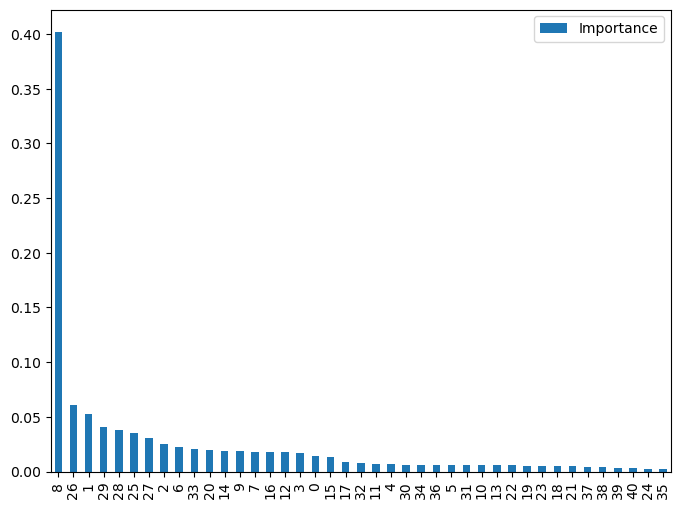

In [31]:

feat_importances = pd.DataFrame({'Feature': X_rem.columns, 'Importance': fittedgrid.best_estimator_.named_steps["model"].feature_importances_,})
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

In [32]:
feat_importances_sm.head(20)

,Feature,Importance
26,AgeCategory,0.173836
8,HadHeartAttack,0.105537
30,AlcoholDrinkers,0.089224
0,Female,0.067024
4,LastCheckupTime,0.066795
5,PhysicalActivities,0.064869
31,HIVTesting,0.047362
36,CovidPos,0.046556
2,PhysicalHealthDays,0.042364
6,SleepHours,0.035982


Model Evaluation

In [14]:
print(f"Best accuracy on the remainder set: {fittedgrid.score(X_rem, y_rem)}")
print(f"Best accuracy on the test set: {fittedgrid.score(X_test, y_test)}")


y_test_pred = fittedgrid.predict(X_test)


conmat = pd.DataFrame(
    data = confusion_matrix(y_test, y_test_pred),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)
display(conmat)

print(f'Recall score: {recall_score(y_test, y_test_pred)*100:0.2f}%')
print(f'Precision score: {precision_score(y_test, y_test_pred)*100:0.2f}%')
print(f'F1 score: {f1_score(y_test, y_test_pred)*100:0.2f}%')

Best accuracy on the remainder set: 0.9568060566028149
Best accuracy on the test set: 0.9442107188586062


,predicted 0,predicted 1
true 0,45873,339
true 1,2406,585


Recall score: 19.56%
Precision score: 63.31%
F1 score: 29.89%


ROC

In [33]:
y_proba = fittedgrid.best_estimator_.predict_proba(X_test)[:,1]

# precision and recall for default (0.5) cut-off
y_threshold = np.where(y_proba > 0.5, 1, 0)

print("Threshold of 0.5:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}",'\n')


# higher cut-off (0.8)
y_threshold = np.where(y_proba > 0.8, 1, 0)

print("Threshold of 0.8:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")


Threshold of 0.5:
Precision score: 0.6331168831168831
Recall score: 0.19558676028084251 

Threshold of 0.8:
Precision score: 1.0
Recall score: 0.00033433634236041456


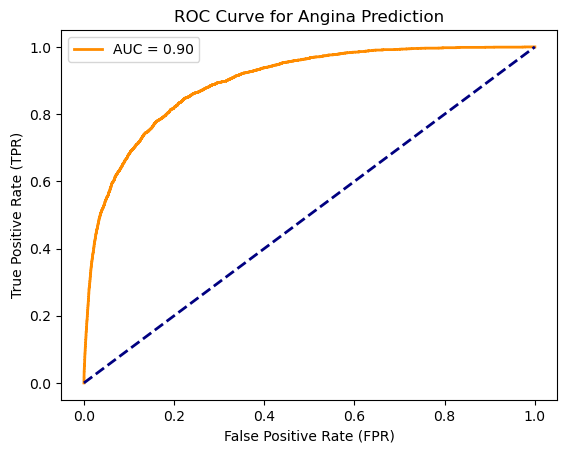

Area under curve (AUC):0.8952475519984461



In [34]:
from sklearn.metrics import roc_curve, roc_auc_score # template block of code

fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Angina Prediction')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()


## Code block sourced from Brainstation Model Evaluation notebook


SMOTE

In [15]:
# SMOTE
from imblearn.over_sampling import SMOTE

X_rem_sm, y_rem_sm = SMOTE(random_state=1).fit_resample(X_rem, y_rem)

In [16]:

print('Original class distribution')
print((y_rem).value_counts().sort_index(),'\n')

print('Resampled class distribution')
print((y_rem_sm).value_counts().sort_index())

Original class distribution
HadAngina
0    184848
1     11962
Name: count, dtype: int64 

Resampled class distribution
HadAngina
0    184848
1    184848
Name: count, dtype: int64


In [17]:
# gridsearch

pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", RandomForestClassifier())], memory=cachedir)
                 
param =  {'scaler': [ StandardScaler()],
          'model__max_depth' : [4, 8, 12],
          'model__n_estimators' : [64, 128] }


grid = GridSearchCV(estimator=pipe,param_grid=param, cv=5,verbose=1,refit=True)

In [18]:
fittedgrid_sm = grid.fit(X_rem_sm,y_rem_sm)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [19]:
fittedgrid_sm.best_params_

{'model__max_depth': 12,
 'model__n_estimators': 128,
 'scaler': StandardScaler()}

In [20]:
fittedgrid_sm.best_estimator_

Pipeline(memory='/var/folders/r3/bz5mjtds4dvdw0hskxwvs9vc0000gp/T/tmpyvthk1ol',
         steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=12, n_estimators=128))])

Model Interpretation

<Axes: >

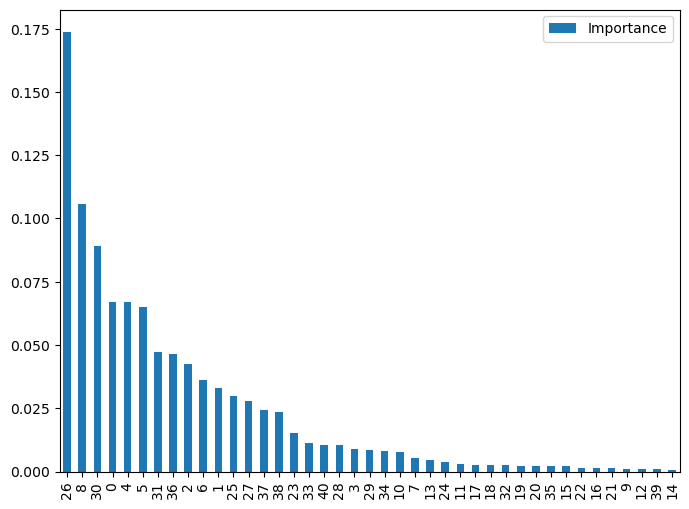

In [29]:

feat_importances_sm = pd.DataFrame({'Feature': X_rem_sm.columns, 'Importance': fittedgrid_sm.best_estimator_.named_steps["model"].feature_importances_,})
feat_importances_sm.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances_sm.plot(kind='bar', figsize=(8,6))

In [30]:
feat_importances_sm.head(20)

,Feature,Importance
26,AgeCategory,0.173836
8,HadHeartAttack,0.105537
30,AlcoholDrinkers,0.089224
0,Female,0.067024
4,LastCheckupTime,0.066795
5,PhysicalActivities,0.064869
31,HIVTesting,0.047362
36,CovidPos,0.046556
2,PhysicalHealthDays,0.042364
6,SleepHours,0.035982


Model Evaluation

In [22]:
print(f"Best accuracy on the remainder set: {fittedgrid_sm.score(X_rem, y_rem)}")
print(f"Best accuracy on the test set: {fittedgrid_sm.score(X_test, y_test)}")


y_test_pred = fittedgrid_sm.predict(X_test)


conmat = pd.DataFrame(
    data = confusion_matrix(y_test, y_test_pred),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)
display(conmat)

print(f'Recall score: {recall_score(y_test, y_test_pred)*100:0.2f}%')
print(f'Precision score: {precision_score(y_test, y_test_pred)*100:0.2f}%')
print(f'F1 score: {f1_score(y_test, y_test_pred)*100:0.2f}%')

Best accuracy on the remainder set: 0.8267618515319344
Best accuracy on the test set: 0.8162307176391683


,predicted 0,predicted 1
true 0,38182,8030
true 1,1012,1979


Recall score: 66.17%
Precision score: 19.77%
F1 score: 30.45%


In [23]:
y_proba = fittedgrid_sm.best_estimator_.predict_proba(X_test)[:,1]

# precision and recall for default (0.5) cut-off
y_threshold = np.where(y_proba > 0.5, 1, 0)

print("Threshold of 0.5:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}",'\n')


# higher cut-off (0.8)
y_threshold = np.where(y_proba > 0.8, 1, 0)

print("Threshold of 0.8:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")

Threshold of 0.5:
Precision score: 0.19772205015486063
Recall score: 0.6616516215312604 

Threshold of 0.8:
Precision score: 0.3909716908951798
Recall score: 0.17084587094617185


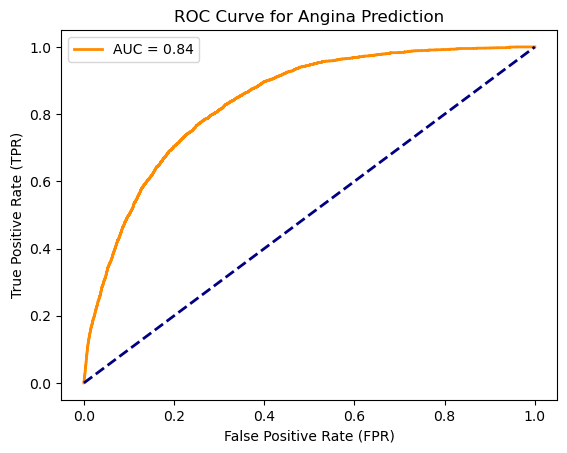

Area under curve (AUC):0.8382557978618622



In [24]:
from sklearn.metrics import roc_curve, roc_auc_score # template block of code

fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Angina Prediction')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()


## Code block sourced from Brainstation Model Evaluation notebook
